In [1]:
# This file will implement the main training loop for a model
from time import time
import argparse
import os

from torch import device
import torch
from torch import optim
from transformers import Adafactor
import numpy as np

from disentanglement_final.data_prep import NLIGenData2, OntoGenData, HuggingYelp2, ParaNMTCuratedData, BARTYelp, \
    BARTParaNMT, BARTNLI
from disentanglement_final.models import DisentanglementTransformerVAE, LaggingDisentanglementTransformerVAE
from disentanglement_final.h_params import DefaultTransformerHParams as HParams
from disentanglement_final.graphs import *
from components.criteria import *
parser = argparse.ArgumentParser()
from torch.nn import MultiheadAttention
# Training and Optimization
k, kz, klstm = 2, 4, 2
parser.add_argument("--test_name", default='unnamed', type=str)
parser.add_argument("--data", default='nli', choices=["nli", "ontonotes", "yelp", 'paranmt'], type=str)
parser.add_argument("--csv_out", default='disentqkv3.csv', type=str)
parser.add_argument("--max_len", default=17, type=int)
parser.add_argument("--init_len", default=None, type=int)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--grad_accu", default=1, type=int)
parser.add_argument("--n_epochs", default=20, type=int)
parser.add_argument("--test_freq", default=16, type=int)
parser.add_argument("--complete_test_freq", default=128, type=int)
parser.add_argument("--generation_weight", default=1, type=float)
parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
parser.add_argument("--embedding_dim", default=128, type=int)#################"
parser.add_argument("--pretrained_embeddings", default=False, type=bool)#################"
parser.add_argument("--z_size", default=96*kz, type=int)#################"
parser.add_argument("--z_emb_dim", default=192*k, type=int)#################"
parser.add_argument("--n_keys", default=4, type=int)#################"
parser.add_argument("--n_latents", default=[4], nargs='+', type=int)#################"
parser.add_argument("--text_rep_l", default=3, type=int)
parser.add_argument("--text_rep_h", default=192*k, type=int)
parser.add_argument("--encoder_h", default=192*k, type=int)#################"
parser.add_argument("--encoder_l", default=2, type=int)#################"
parser.add_argument("--decoder_h", default=int(192*k), type=int)################
parser.add_argument("--decoder_l", default=2, type=int)#################"
parser.add_argument("--highway", default=False, type=bool)
parser.add_argument("--markovian", default=True, type=bool)
parser.add_argument('--minimal_enc', dest='minimal_enc', action='store_true')
parser.add_argument('--no-minimal_enc', dest='minimal_enc', action='store_false')
parser.set_defaults(minimal_enc=False)
parser.add_argument('--use_bart', dest='use_bart', action='store_true')
parser.add_argument('--no-use_bart', dest='use_bart', action='store_false')
parser.set_defaults(use_bart=False)
parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE" "LagVAE"], type=str)
parser.add_argument("--graph", default='Normal', choices=["Vanilla", "IndepInfer", "QKV", "SQKV", "HQKV", "HQKVDiscZs"],
                    type=str)
parser.add_argument("--training_iw_samples", default=1, type=int)
parser.add_argument("--testing_iw_samples", default=5, type=int)
parser.add_argument("--test_prior_samples", default=10, type=int)
parser.add_argument("--anneal_kl0", default=3000, type=int)
parser.add_argument("--anneal_kl1", default=6000, type=int)
parser.add_argument("--zs_anneal_kl0", default=7000, type=int)
parser.add_argument("--zs_anneal_kl1", default=10000, type=int)
parser.add_argument("--zg_anneal_kl0", default=7000, type=int)
parser.add_argument("--zg_anneal_kl1", default=10000, type=int)
parser.add_argument("--anneal_kl_type", default="linear", choices=["linear", "sigmoid"], type=str)
parser.add_argument("--optimizer", default="adam", choices=["adam", "sgd"], type=str)
parser.add_argument("--grad_clip", default=5., type=float)
parser.add_argument("--kl_th", default=0., type=float or None)
parser.add_argument("--max_elbo1", default=6.0, type=float)
parser.add_argument("--max_elbo2", default=4.0, type=float)
parser.add_argument("--max_elbo_choice", default=6, type=int)
parser.add_argument("--kl_beta", default=0.3, type=float)
parser.add_argument("--kl_beta_zs", default=0.1, type=float)
parser.add_argument("--kl_beta_zg", default=0.1, type=float)
parser.add_argument("--dropout", default=0.3, type=float)
parser.add_argument("--word_dropout", default=0.4, type=float)
parser.add_argument("--l2_reg", default=0, type=float)
parser.add_argument("--lr", default=2e-4, type=float)
parser.add_argument("--lr_reduction", default=4., type=float)
parser.add_argument("--wait_epochs", default=1, type=float)
parser.add_argument("--save_all", default=True, type=bool)

flags, _ = parser.parse_known_args()
# Manual Settings, Deactivate before pushing

if True:
    # flags.optimizer="sgd"
    flags.use_bart = True
    flags.batch_size = 10
    flags.max_len = 40
    flags.test_name = "nliLM/ParaQKVBARTmini_beta0.3.0.3.1.8" #ParaQKVBARTminiThr_beta0.2.0.2.1.8.pth" 
    flags.data = "paranmt"
    flags.n_latents = [8]
    flags.graph ="QKV"  
    flags.kl_beta = 0.3
    flags.max_elbo_choice = 6
    flags.kl_beta_zs = 0.3
    flags.z_size = 192
    
if flags.use_bart:
    flags.decoder_h = 768
    flags.encoder_h = 768
    flags.embedding_dim = 768


if flags.anneal_kl_type == "sigmoid" and flags.anneal_kl0 < flags.anneal_kl1:
    flags.anneal_kl0, flags.anneal_kl1 = 2000, 500
    flags.zs_anneal_kl0, flags.zs_anneal_kl1 = 4000, 500
    flags.zg_anneal_kl0, flags.zg_anneal_kl1 = 4000, 500


if flags.use_bart and flags.optimizer == "adam": flags.optimizer = "adafactor"
OPTIMIZER = {'sgd': optim.SGD, 'adam': optim.Adam, "adafactor": Adafactor}[flags.optimizer]
OPT_KWARGS = {'sgd': {'lr': flags.lr, 'weight_decay': flags.l2_reg},  # 't0':100, 'lambd':0.},
              'adam': {'lr': flags.lr, 'weight_decay': flags.l2_reg, 'betas': (0.9, 0.99)},
              'adafactor': {'lr': flags.lr, 'relative_step': False,
                            'weight_decay': flags.l2_reg}}[flags.optimizer]

# torch.autograd.set_detect_anomaly(True)
GRAPH = {"Vanilla": get_vanilla_graph,
         "IndepInfer": get_BARTADVAE if flags.use_bart else get_structured_auto_regressive_indep_graph,
         "QKV": get_qkv_graphBART if flags.use_bart else get_qkv_graph2,
         "SQKV": get_min_struct_qkv_graphBART if flags.use_bart else None,
         "HQKV": get_hqkv_graphBART if flags.use_bart else get_hqkv_graph,
         "HQKVDiscZs": get_hqkv_graph_discrete_zsBART if flags.use_bart else get_hqkv_graph_discrete_zs}[flags.graph]
if flags.graph == "NormalLSTM":
    flags.encoder_h = int(flags.encoder_h/k*klstm)
if flags.graph == "Vanilla":
    flags.n_latents = [flags.z_size]
if flags.losses == "LagVAE":
    flags.anneal_kl0 = 0
    flags.anneal_kl1 = 0
Data = {"nli": BARTNLI if flags.use_bart else NLIGenData2, "ontonotes": OntoGenData,
        "yelp": BARTYelp if flags.use_bart else HuggingYelp2,
        "paranmt": BARTParaNMT if flags.use_bart else ParaNMTCuratedData}[flags.data]
MAX_LEN = flags.max_len
BATCH_SIZE = flags.batch_size
GRAD_ACCU = flags.grad_accu
N_EPOCHS = flags.n_epochs
TEST_FREQ = flags.test_freq
COMPLETE_TEST_FREQ = flags.complete_test_freq
DEVICE = device(flags.device)
# This prevents illegal memory access on multigpu machines (unresolved issue on torch's github)
if flags.device.startswith('cuda'):
    torch.cuda.set_device(int(flags.device[-1]))
LOSSES = {'IWAE': [IWLBo],
          'VAE': [ELBo],
          'LagVAE': [ELBo]}[flags.losses]

ANNEAL_KL = [flags.anneal_kl0*flags.grad_accu, flags.anneal_kl1*flags.grad_accu]
ZS_ANNEAL_KL = [flags.zs_anneal_kl0*flags.grad_accu, flags.zs_anneal_kl1*flags.grad_accu]
ZG_ANNEAL_KL = [flags.zg_anneal_kl0*flags.grad_accu, flags.zg_anneal_kl1*flags.grad_accu]
LOSS_PARAMS = [1]
if flags.grad_accu > 1:
    LOSS_PARAMS = [w/flags.grad_accu for w in LOSS_PARAMS]

data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, pretrained=flags.pretrained_embeddings)
h_params = HParams(len(data.vocab.itos), len(data.tags.itos) if (flags.data == 'yelp' and not flags.use_bart)
                   else None, MAX_LEN, BATCH_SIZE, N_EPOCHS,
                   device=DEVICE, vocab_ignore_index=data.vocab.stoi['<pad>'], decoder_h=flags.decoder_h,
                   decoder_l=flags.decoder_l, encoder_h=flags.encoder_h, encoder_l=flags.encoder_l,
                   text_rep_h=flags.text_rep_h, text_rep_l=flags.text_rep_l,
                   test_name=flags.test_name, grad_accumulation_steps=GRAD_ACCU,
                   optimizer_kwargs=OPT_KWARGS,
                   is_weighted=[], graph_generator=GRAPH, z_size=flags.z_size, embedding_dim=flags.embedding_dim,
                   anneal_kl=ANNEAL_KL, zs_anneal_kl=ZS_ANNEAL_KL, zg_anneal_kl=ZG_ANNEAL_KL,
                   grad_clip=flags.grad_clip*flags.grad_accu, kl_th=flags.kl_th, highway=flags.highway,
                   losses=LOSSES, dropout=flags.dropout, training_iw_samples=flags.training_iw_samples,
                   testing_iw_samples=flags.testing_iw_samples, loss_params=LOSS_PARAMS, optimizer=OPTIMIZER,
                   markovian=flags.markovian, word_dropout=flags.word_dropout, contiguous_lm=False,
                   test_prior_samples=flags.test_prior_samples, n_latents=flags.n_latents, n_keys=flags.n_keys,
                   max_elbo=[flags.max_elbo_choice, flags.max_elbo1],
                   z_emb_dim=flags.z_emb_dim, minimal_enc=flags.minimal_enc, kl_beta=flags.kl_beta,
                   kl_beta_zs=flags.kl_beta_zs, kl_beta_zg=flags.kl_beta_zg, anneal_kl_type=flags.anneal_kl_type)
val_iterator = iter(data.val_iter)
print("Words: ", len(data.vocab.itos), ", On device: ", DEVICE.type, flush=True)
print("Loss Type: ", flags.losses)
if flags.losses == 'LagVAE':
    model = LaggingDisentanglementTransformerVAE(data.vocab, data.tags, h_params, wvs=data.wvs, dataset=data,
                                                 enc_iter=data.enc_train_iter)
else:
    model = DisentanglementTransformerVAE(data.vocab, data.tags, h_params, wvs=data.wvs, dataset=data)
if DEVICE.type == 'cuda':
    model.cuda(DEVICE)

# Redefining examples lengths:
if flags.init_len is not None:
    data.redefine_max_len(flags.init_len)
    h_params.max_len = flags.init_len

total_unsupervised_train_samples = len(data.train_iter)*BATCH_SIZE
total_unsupervised_val_samples = len(data.val_iter)*(BATCH_SIZE/data.divide_bs)
print("Unsupervised training examples: ", total_unsupervised_train_samples)
print("Unsupervised val examples: ", total_unsupervised_val_samples)
number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.infer_bn.parameters() if p.requires_grad)
print("Inference parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.gen_bn.parameters() if p.requires_grad)
print("Generation parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.word_embeddings.parameters() if p.requires_grad)
print("Embedding parameters: ", "{0:05.2f} M".format(number_parameters/1e6))


model.eval()


Using custom data configuration default-b97e0f2e99bae8b9


Reusing dataset csv (C:\Users\ghazy\.cache\huggingface\datasets\csv\default-b97e0f2e99bae8b9\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Words:  50265 , On device:  cuda


Loss Type:  VAE


reconstruction net size: 140.31 M


x to z1 size: 140.05 M
x to zst size: 140.31 M


Loaded model at step 947715


Unsupervised training examples:  493080
Unsupervised val examples:  500.0
Number of parameters:  281.25 M
Inference parameters:  179.54 M
Generation parameters:  140.31 M
Embedding parameters:  38.60 M


In [4]:
model.gen_bn.clear_values(), model.infer_bn.clear_values(), torch.cuda.empty_cache()
model.beam_size = 3
text, samples, params = model.get_sentences(3, gen_len=20, sample_w=False, vary_z=True, complete=None,
                                            contains=None, max_tries=100)

# text = [sen.split(model.eos_symbol)[0].replace(model.go_symbol, '') for sen in text]
print(text)

['how about sorcery?', 'get off of a hamburger!', "you're not gon na get it."]


In [6]:
alt_text, alt_samples = model._get_alternative_sentences(samples, params, [sum(h_params.n_latents)], 3, 20, complete=None)
print("====== Changing Structure=======")
for i in range(len(text)):
    print("-->", text[i], '|<', '><'.join(alt_text[i::len(text)]), '>')
alt_text, alt_samples = model._get_alternative_sentences(samples, params, list(range(sum(h_params.n_latents))), 3, 20, complete=None)
print("====== Changing Content=======")
for i in range(len(text)):
    print("-->", text[i], '|<', '><'.join(alt_text[i::len(text)]), '>')

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 4.25 GiB already allocated; 1.56 MiB free; 4.33 GiB reserved in total by PyTorch)

In [14]:

def swap_latents(mdl, prev_latent_vals, var_z_ids, gen_len, complete=None, no_unk=True):
            has_struct = 'zs' in mdl.gen_bn.name_to_v
            has_zg = 'zg' in mdl.gen_bn.name_to_v
            
            
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            n_samples = n_orig_sentences
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi[mdl.go_symbol]
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device) * \
                        mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            temp = 1.
            orig_z = prev_latent_vals['z1'].unsqueeze(1).repeat(1, n_samples, 1)
            z_sample = orig_z.reshape(n_samples*n_orig_sentences, -1)
            orig_z = orig_z.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1)
            if has_struct:
                orig_zst = prev_latent_vals['zs'].unsqueeze(1).repeat(1, n_samples, 1)
                zst_sample = orig_zst.reshape(n_samples*n_orig_sentences, -1)
                orig_zst = orig_zst.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1)
            if has_zg:
                orig_zg = prev_latent_vals['zg'].unsqueeze(1).repeat(1, n_samples, 1)
                orig_zg = orig_zg.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1)
            

            for id in var_z_ids:
                if id < sum(h_params.n_latents):
                    z_number = sum([id> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
                    z_index = id - sum(h_params.n_latents[:z_number])
                    start, end = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                                 int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
                    source, destination = [z_sample][z_number], [orig_z][z_number]
                    destination[:, start:end] = source[:, start:end]
                elif id == sum(h_params.n_latents) and has_struct:
                    orig_zst = zst_sample
                else:
                    raise IndexError("You gave a too high z_id for swapping with this model")
                    
            z_input = {'z1': orig_z.unsqueeze(1), **({'zs':orig_zst.unsqueeze(1)} if has_struct else {}), 
                       **({'zg':orig_zg.unsqueeze(1)} if has_zg else {})}
            
            x_prev = mdl.generate_from_z2(z_input, x_prev, beam_size=mdl.beam_size)
            text = mdl.decode_to_text2(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': orig_z}
sw_zs = [16]
model.infer_bn.clear_values(), model.gen_bn.clear_values()
torch.cuda.empty_cache()
model.beam_size = 3
print("========== BEAM SIZE: {} ==================".format(model.beam_size))
sw_text, sw_samples = swap_latents(model, samples, sw_zs, 40, complete=None, no_unk=True)
print(text)
for i in range(len(text)):
    for j in range(len(text)):
        if i!=j:
            print("z_from: ", text[i], "|z_to: ", text[j], "|result: ", sw_text[len(text)*i+j])
model.beam_size = 1
print("========== BEAM SIZE: {} ==================".format(model.beam_size))
sw_text, sw_samples = swap_latents(model, samples, sw_zs, 40, complete=None, no_unk=True)
print(text)
for i in range(len(text)):
    for j in range(len(text)):
        if i!=j:
            print("z_from: ", text[i], "|z_to: ", text[j], "|result: ", sw_text[len(text)*i+j])

========== BEAM SIZE: 2 ==================


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 4.22 GiB already allocated; 1.56 MiB free; 4.33 GiB reserved in total by PyTorch)

In [4]:
scores3 = model.get_swap_tma(200, 10, 4)

Generating original sentences:   0%|          | 0/19 [00:00<?, ?it/s]

Generating original sentences:   5%|▌         | 1/19 [00:02<00:45,  2.52s/it]

Generating original sentences:  11%|█         | 2/19 [00:04<00:42,  2.51s/it]

Generating original sentences:  16%|█▌        | 3/19 [00:07<00:40,  2.50s/it]

Generating original sentences:  21%|██        | 4/19 [00:09<00:37,  2.49s/it]

Generating original sentences:  26%|██▋       | 5/19 [00:12<00:34,  2.48s/it]

Generating original sentences:  32%|███▏      | 6/19 [00:15<00:35,  2.69s/it]

Generating original sentences:  37%|███▋      | 7/19 [00:19<00:35,  2.92s/it]

Generating original sentences:  42%|████▏     | 8/19 [00:21<00:30,  2.80s/it]

Generating original sentences:  47%|████▋     | 9/19 [00:24<00:27,  2.72s/it]

Generating original sentences:  53%|█████▎    | 10/19 [00:26<00:24,  2.67s/it]

Generating original sentences:  58%|█████▊    | 11/19 [00:29<00:21,  2.70s/it]

Generating original sentences:  63%|██████▎   | 12/19 [00:32<00:19,  2.76s/it]

Generating original sentences:  68%|██████▊   | 13/19 [00:35<00:16,  2.79s/it]

Generating original sentences:  74%|███████▎  | 14/19 [00:37<00:13,  2.73s/it]

Generating original sentences:  79%|███████▉  | 15/19 [00:40<00:10,  2.69s/it]

Generating original sentences:  84%|████████▍ | 16/19 [00:43<00:08,  2.76s/it]

Generating original sentences:  89%|████████▉ | 17/19 [00:46<00:05,  2.74s/it]

Generating original sentences:  95%|█████████▍| 18/19 [00:48<00:02,  2.70s/it]

Generating original sentences: 100%|██████████| 19/19 [00:51<00:00,  2.66s/it]

Generating original sentences: 100%|██████████| 19/19 [00:51<00:00,  2.69s/it]


Getting Model Swap TMA:   0%|          | 0/10 [00:00<?, ?it/s]

Getting Model Swap TMA:  10%|█         | 1/10 [00:06<00:54,  6.09s/it]

Getting Model Swap TMA:  20%|██        | 2/10 [00:12<00:49,  6.19s/it]

Getting Model Swap TMA:  30%|███       | 3/10 [00:18<00:43,  6.25s/it]

Getting Model Swap TMA:  40%|████      | 4/10 [00:25<00:37,  6.22s/it]

Getting Model Swap TMA:  50%|█████     | 5/10 [00:31<00:31,  6.22s/it]

Getting Model Swap TMA:  60%|██████    | 6/10 [00:37<00:24,  6.24s/it]

Getting Model Swap TMA:  70%|███████   | 7/10 [00:43<00:18,  6.26s/it]

Getting Model Swap TMA:  80%|████████  | 8/10 [00:50<00:12,  6.29s/it]

Getting Model Swap TMA:  90%|█████████ | 9/10 [00:56<00:06,  6.32s/it]

Getting Model Swap TMA: 100%|██████████| 10/10 [01:03<00:00,  6.35s/it]

Getting Model Swap TMA: 100%|██████████| 10/10 [01:03<00:00,  6.31s/it]

Calculating zs tma...


E:\ProgramData\Anaconda3\lib\site-packages\supar\utils\alg.py:522: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return [sorted(i.nonzero().tolist(), key=lambda x:(x[0], -x[1])) for i in marginals.permute(3, 0, 1, 2)]


Calculating zc tma...


Calculating copy tma...


Calculating bleu scores...


In [21]:
print(scores)
print(scores2)
print(scores3)

{'tma2': {'zs': 53.0, 'zc': 39.0, 'copy': 39.0}, 'tma3': {'zs': 23.0, 'zc': 10.0, 'copy': 5.0}, 'bleu': {'zs': 4.301619841342148, 'zc': 5.329606584392295, 'copy': 2.907042530089797}}
{'tma2': {'zs': 52.0, 'zc': 27.0, 'copy': 28.000000000000004}, 'tma3': {'zs': 21.0, 'zc': 4.0, 'copy': 2.0}, 'bleu': {'zs': 4.837286465792402, 'zc': 1.06716549568883, 'copy': 4.533625890054019}}
{'tma2': {'zs': 46.2, 'zc': 38.0, 'copy': 34.699999999999996}, 'tma3': {'zs': 15.4, 'zc': 4.7, 'copy': 9.2}, 'bleu': {'zs': 5.6330959118116475, 'zc': 1.500889607364273, 'copy': 4.732771442981089}}


In [7]:
print(scores1, scores3)

{'tma2': {'zs': 56.99999999999999, 'zc': 42.0, 'copy': 41.0}, 'tma3': {'zs': 23.0, 'zc': 8.0, 'copy': 6.0}, 'bleu': {'zs': 7.672990358203783, 'zc': 3.623395667548363, 'copy': 2.1395611292167582}} {'tma2': {'zs': 54.0, 'zc': 43.0, 'copy': 35.0}, 'tma3': {'zs': 26.0, 'zc': 8.0, 'copy': 5.0}, 'bleu': {'zs': 15.2429080729265, 'zc': 0.0, 'copy': 2.7638331671257435}}


In [6]:
scores1 = model.get_swap_tma(200, 10, 1)

Generating original sentences:   0%|          | 0/19 [00:00<?, ?it/s]

Generating original sentences:   5%|▌         | 1/19 [00:03<01:01,  3.44s/it]

Generating original sentences:  11%|█         | 2/19 [00:06<00:55,  3.29s/it]

Generating original sentences:  16%|█▌        | 3/19 [00:09<00:50,  3.18s/it]

Generating original sentences:  21%|██        | 4/19 [00:12<00:46,  3.09s/it]

Generating original sentences:  26%|██▋       | 5/19 [00:15<00:44,  3.17s/it]

Generating original sentences:  32%|███▏      | 6/19 [00:18<00:40,  3.12s/it]

Generating original sentences:  37%|███▋      | 7/19 [00:21<00:36,  3.03s/it]

Generating original sentences:  42%|████▏     | 8/19 [00:24<00:32,  2.98s/it]

Generating original sentences:  47%|████▋     | 9/19 [00:27<00:29,  2.93s/it]

Generating original sentences:  53%|█████▎    | 10/19 [00:29<00:26,  2.92s/it]

Generating original sentences:  58%|█████▊    | 11/19 [00:32<00:23,  2.91s/it]

Generating original sentences:  63%|██████▎   | 12/19 [00:35<00:20,  2.91s/it]

Generating original sentences:  68%|██████▊   | 13/19 [00:38<00:17,  2.95s/it]

Generating original sentences:  74%|███████▎  | 14/19 [00:41<00:14,  2.93s/it]

Generating original sentences:  79%|███████▉  | 15/19 [00:44<00:11,  2.91s/it]

Generating original sentences:  84%|████████▍ | 16/19 [00:47<00:08,  2.92s/it]

Generating original sentences:  89%|████████▉ | 17/19 [00:50<00:05,  2.94s/it]

Generating original sentences:  95%|█████████▍| 18/19 [00:53<00:02,  2.97s/it]

Generating original sentences: 100%|██████████| 19/19 [00:56<00:00,  2.99s/it]

Generating original sentences: 100%|██████████| 19/19 [00:56<00:00,  2.98s/it]


Getting Model Swap TMA:   0%|          | 0/10 [00:00<?, ?it/s]

Getting Model Swap TMA:  10%|█         | 1/10 [00:01<00:14,  1.60s/it]

Getting Model Swap TMA:  20%|██        | 2/10 [00:03<00:13,  1.73s/it]

Getting Model Swap TMA:  30%|███       | 3/10 [00:06<00:13,  1.92s/it]

Getting Model Swap TMA:  40%|████      | 4/10 [00:07<00:11,  1.88s/it]

Getting Model Swap TMA:  50%|█████     | 5/10 [00:09<00:09,  1.81s/it]

Getting Model Swap TMA:  60%|██████    | 6/10 [00:11<00:07,  1.76s/it]

Getting Model Swap TMA:  70%|███████   | 7/10 [00:13<00:05,  1.82s/it]

Getting Model Swap TMA:  80%|████████  | 8/10 [00:14<00:03,  1.80s/it]

Getting Model Swap TMA:  90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]

Getting Model Swap TMA: 100%|██████████| 10/10 [00:18<00:00,  1.79s/it]

Getting Model Swap TMA: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]

Calculating zs tma...


Calculating zc tma...


Calculating copy tma...


Calculating bleu scores...


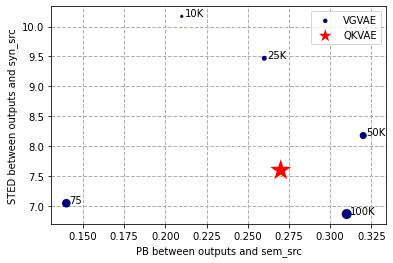

In [2]:
# ParaBART score to STED figure
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
"""
Scores to show for VGVAE[10, 25, 50, 75, 100, 435] and QKVAE:

"""
my_STED_syn = [7.6]
my_STED_targ = [9.07]
my_PB_sem = [0.27]
my_PB_targ = [0.27]
Last=True
if Last:
    n = ['10K', '25K', '50K', '75', 
         '100K', #'200K', #'493K'
         ]
    sizes = [10, 25, 50, 75,
                        100, #200, #493
             ]
    STED_syn = [10.17, 9.47, 8.18, 7.05, 
                6.87, #7.16, #3.34
                ]
    STED_targ = [11.12, 10.87, 9.85, 9.7, 
                 9.29, #9.54, #6.66
                 ]
    PB_sem = [0.21, 0.26, 0.32, 0.14, 
              0.31, #0.32, #0.58
              ]
    PB_targ = [0.21, 0.27, 0.32, 0.16, 
               0.32, #0.33, #0.58
               ]
else:
    n = ['10K', '25K', '50K', #'75', 
         '100K', '200K', #'493K'
         ]
    sizes = [10, 25, 50, 100, 200]
    STED_syn = [10.05, 9.15, 8.98, 8.91, 6.87]
    STED_targ = [11.06, 10.43, 10.22, 10.35, 9.33]
    PB_sem = [0.21, 0.26, 0.30, 0.28, 0.32]
    PB_targ = [0.21, 0.26, 0.30, 0.28, 0.32]
    
z, y = PB_sem, STED_syn
plt.scatter(z, y,
               c = 'navy',#'['cyan', 'skyblue', 'blue', 'navy', 'black'],
               s = sizes,
               marker = 'o', edgecolors = 'none', label="VGVAE")
for i, txt in enumerate(n):
    plt.annotate(txt, (z[i]+0.002,
                       y[i]))#"+0.05))
plt.xlim(plt.xlim()[0], plt.xlim()[1]+0.005)
plt.grid(linewidth=1, linestyle='--')

plt.gca().set_axisbelow(True)
plt.scatter(my_PB_sem, my_STED_syn,
               c = 'red',#'['cyan', 'skyblue', 'blue', 'navy', 'black'],
               s=493, marker = '*', edgecolors = 'none', label="QKVAE")
plt.legend(loc='upper right', markerscale=0.6)
plt.xlabel("PB between outputs and sem_src")
plt.ylabel("STED between outputs and syn_src")
plt.savefig('PBvsSTED.pdf')
# plt.plot([0, 4], [0, 8], color = 'red', linestyle = 'solid')
# plt.title('styles variables et droite')


Text(0, 0.5, 'STED between outputs and syn_src')

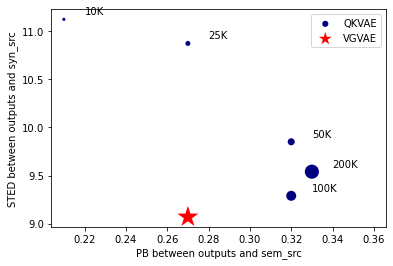

In [15]:

z, y = PB_targ, STED_targ
plt.scatter(z, y,
               c = 'navy',#'['cyan', 'skyblue', 'blue', 'navy', 'black'],
               s = sizes,
               marker = 'o', edgecolors = 'none', label="VGVAE")
for i, txt in enumerate(n):
    plt.annotate(txt, (z[i]+0.01, y[i]+0.05))
plt.xlim(plt.xlim()[0], plt.xlim()[1]+0.03)
plt.grid(linewidth=1, linestyle='--')

plt.gca().set_axisbelow(True)
plt.scatter(my_PB_targ, my_STED_targ,
               c = 'red',#'['cyan', 'skyblue', 'blue', 'navy', 'black'],
               s=493, marker = '*', edgecolors = 'none', label="QKVAE")
plt.legend(loc='upper right', markerscale=0.6)
plt.xlabel("PB between outputs and sem_src")
plt.ylabel("STED between outputs and syn_src")